In [2]:
# import matplotlib
# matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import pandas as pd

In [6]:
import itertools
import numpy as np

class Datapoint:
    def __init__(self, t, s, g, sent):
        self.toxicity = t
        self.similarity = s
        self.generation = g
        self.additional = sent

def get_metadata_from_file(datafilenum):
    metadata_file = f"../data/output{datafilenum}.metadata"
    
    metadata = {}
    with open(metadata_file, "r") as f:
        for line in f.readlines():
            key, val = line.split(",", maxsplit=1)
            metadata[key] = val

    return metadata

def get_data_from_file(datafilenum):
    data_file = f"../data/output{datafilenum}.csv"
    
    result = []
    with open(data_file, "r") as f:
        f.readline()
        for line in f.readlines():
            parts = line.split(",", maxsplit=3)
            result.append(Datapoint(float(parts[0]), float(parts[1]), int(parts[2]), parts[3]))

    return result

def statistics_per_generation(datapoints):
    by_gen = [list(v) for l, v in itertools.groupby(datapoints, lambda x: x.generation)]
    return (
        [np.mean(sorted([float(x.toxicity) for x in data])[0:15]) for data in by_gen],
        [np.min([x.similarity for x in data][0:10]) for data in by_gen]
    )


In [7]:
def make_regression_tox_dist(datafilenum: int):
    datapoints = get_data_from_file(datafilenum)
    cnt = len([1 for x in datapoints if float(x.additional) < 1])
    if cnt == 0:
        print("skip")
        return
    x_vals = np.array([float(x.additional) for x in datapoints if float(x.additional) < 1])
    y_vals = np.array([x.toxicity for x in datapoints if float(x.additional) < 1])

    # print(np.std(x_vals), np.std(y_vals))
    
    
    m, b = np.polyfit(x_vals, y_vals, 1)
    plt.plot(x_vals, m*x_vals + b, color="red")
    print("corr: ", np.corrcoef(x_vals, y_vals)[0][1])
    plt.scatter(x_vals, y_vals)

  distance_param  thresholds      num_children    pool_size    crossover
----------------  ------------  --------------  -----------  -----------
             192  [0.5]                     10           15           40
             192  [0.3]                     10           15           40
             192  [0.1]                     10           15           40


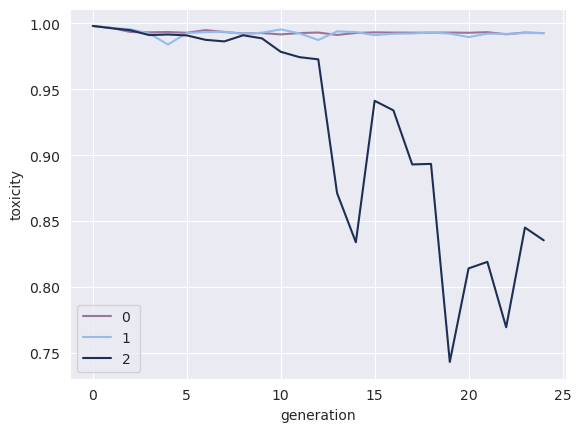

corr:  0.2510694418816857
corr:  0.15986763598515907
corr:  0.24010838876189972


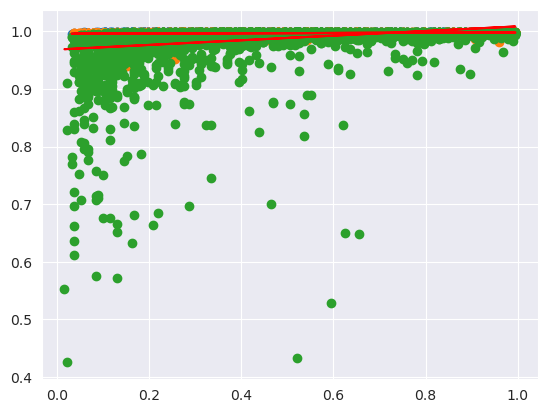

In [8]:
import random
from random import randrange
import tabulate

def rand_color():
    return [randrange(255) / 255, randrange(255) /255, randrange(255)/255]


def print_metadata(dataset):
    header = dataset[0].keys()
    rows =  [x.values() for x in dataset]
    print(tabulate.tabulate(rows, header))

def show_generational_statistic_plot(datafilenums: list[int]):
    fig, ax = plt.subplots()
    plt.xlabel("generation")
    plt.ylabel("toxicity")

    data_list = [statistics_per_generation(get_data_from_file(id)) for id in datafilenums]
    metadata_list = [get_metadata_from_file(id) for id in datafilenums]

    for index, data in enumerate(data_list):
        x_data = [i for i in range(len(data[0]))]
        y_data = [x if x != 1 else 1 for x in data[0]] 

        
        ax.plot(x_data, y_data, color=rand_color(), label=f"{index} ")
        
    ax.legend()

    print_metadata(metadata_list)
    plt.show()
        

dataids = [61, 62, 63]
show_generational_statistic_plot(dataids)
for id in dataids:
    make_regression_tox_dist(id)
# make_regression_tox_dist(34)
# make_regression_tox_dist(54)
# make_regression_tox_dist(55)
# make_regression_tox_dist(56)
# make_regression_tox_dist(35)
# make_regression_tox_dist(51)



In [9]:
def show_scatter_plot(datafilenum: int):
    datapoints = get_data_from_file(datafilenum)
    fig, ax = plt.subplots()
    ax.scatter([x.toxicity for x in datapoints], [x.similarity for x in datapoints])
    ax.set_xlabel("toxicity")
    ax.set_ylabel("similarity")
    plt.show()

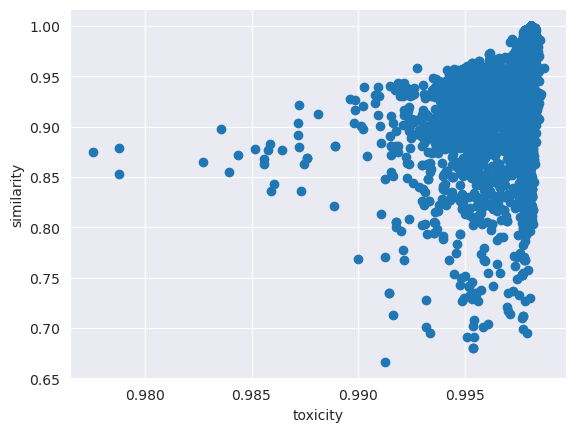

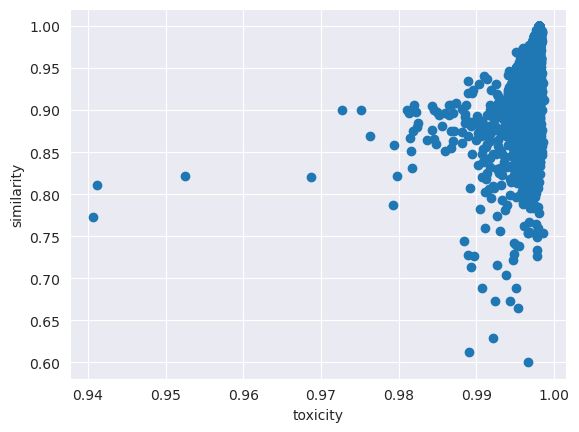

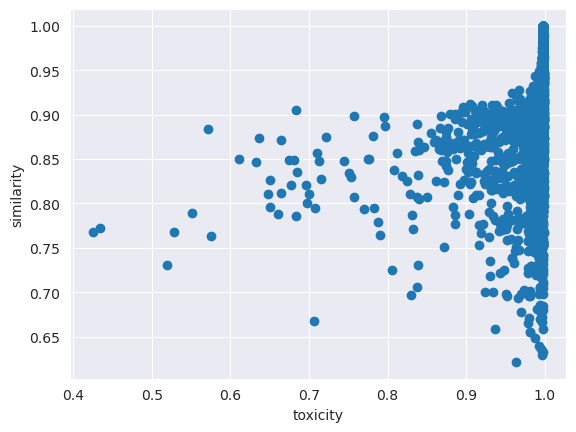

In [10]:
for id in dataids:
    show_scatter_plot(id)

## dataset 10, 11:
Population based search. Keep the upper frontier at all times, to generate the next sentence, find a new item at random and morph it. Total 1000 generations of this. Add % = 40

## dataset 12
same as above but add percent is 50

## dataset 13
same as above but add percent is 30

## dataset 14
The frontier is more loosely maintained, with some randomness set to 30% a suboptimal point might still be kept in the frontier. 

## dataset 16
We change the distance function to be 0/1, and the toxicity displayed here is just a measure of how many perturbations is it away from being a non-toxic prompt. 

## dataset 24-26
We use the same SLS as before. 10*10 for 25 generations. however the toxicity measured is now a max of the individual categories
morpher is random word morpher.

## metadata